3. Mixed Logit (Random Coefficients Logit)

In [1]:
pip install pyblp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 868 kB 2.1 MB/s 


In [2]:
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False

In [3]:
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
product_data.head()

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.012417,0.072088,2,1,...,2.116358,-0.154708,-0.005796,0.014538,0.126244,0.067345,0.068423,0.034800,0.126346,0.035484
1,C01Q1,1,1,F1B06,1,6,0.007809,0.114178,18,1,...,-7.374091,-0.576412,0.012991,0.076143,0.029736,0.087867,0.110501,0.087784,0.049872,0.072579
2,C01Q1,1,1,F1B07,1,7,0.012995,0.132391,4,1,...,2.187872,-0.207346,0.003509,0.091781,0.163773,0.111881,0.108226,0.086439,0.122347,0.101842
3,C01Q1,1,1,F1B09,1,9,0.005770,0.130344,3,0,...,2.704576,0.040748,-0.003724,0.094732,0.135274,0.088090,0.101767,0.101777,0.110741,0.104332
4,C01Q1,1,1,F1B11,1,11,0.017934,0.154823,12,0,...,1.261242,0.034836,-0.000568,0.102451,0.130640,0.084818,0.101075,0.125169,0.133464,0.121111


In [4]:
#setting up integration method
mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})
mc_integration

Configured to construct nodes and weights with Monte Carlo simulation with options {seed: 0}.

In [5]:
#setting up optimization method
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})

In [6]:
X1_formulation = pyblp.Formulation('1 + prices + sugar + mushy')# this is equation for delta
X2_formulation = pyblp.Formulation('1 + prices + sugar + mushy') #this is equation for mu, in this case, X1 and X2 are the same
product_formulations = (X1_formulation, X2_formulation)
product_formulations

(1 + prices + sugar + mushy, 1 + prices + sugar + mushy)

In [7]:
mc_problem = pyblp.Problem(product_formulations, product_data, integration=mc_integration)
mc_problem

Dimensions:
 T    N     F    I     K1    K2    MD 
---  ----  ---  ----  ----  ----  ----
94   2256   5   4700   4     4     23 

Formulations:
       Column Indices:          0     1       2      3  
-----------------------------  ---  ------  -----  -----
 X1: Linear Characteristics     1   prices  sugar  mushy
X2: Nonlinear Characteristics   1   prices  sugar  mushy

In [9]:
#estimating mixed logit for the case where sigma is known to be diagonal (no covariance between different betas)
#we specify an initial point for sigma via sigma = initial point
#but np.eye(4) is just a identity matrix of size 4, 
#so it has zeros off the main diagonal
#so pyblp will constrain the off-diagonal terms to be zeros
#so we effectively constrain our sigma to be diagonal.
#we need at least 1 (for price) + 4 (for sigma) = 5 excluded instruments 
#but we have 20 excluded instruments, 5<=20, so we are good
results1 = mc_problem.solve(sigma=np.eye(4), optimization=bfgs)

In [11]:
results1

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +1.8E+02   +2.8E-05     +6.6E-01        +5.9E+03        0         +3.4E+08          +1.3E+07     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:52       Yes          21           31          30530        94121   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy   
------  ----------  ----------  ----------  ----------
  1      +8.1E-02                                     
    

Above, Sigma is the estimated matrix of standard deviations, not variances.

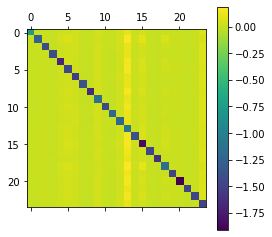

In [12]:
#computing elasticities
elasticities = results1.compute_elasticities()
#computing matrix of elasticities in a single market
single_market = product_data['market_ids'] == 'C01Q1'
#elasticities[single_market]
plt.colorbar(plt.matshow(elasticities[single_market]))

In [13]:
beta=results1.beta
wtp_sugar=-beta[2]/beta[1]
print(wtp_sugar)

[0.00251877]


In [14]:
#estimation assuming an arbitrary positive definite, symmetic covariance matrix
# we need 1+ 10=11 instruments; 11<=20, hence we are good
#starting point np.ones(4,4) - matrix of all ones, so there are no zeros.
results2 = mc_problem.solve(sigma=np.ones((4,4)), optimization=bfgs)
results2

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +1.2E+02   +9.5E-05     +9.6E-02        +1.8E+04        0         +3.1E+08          +6.7E+07     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:03:12       Yes          74           94         106925       328566   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |  Sigma Squared:      1         prices      sugar       mushy   
------  ----------  ----------  ----------  ---

In [15]:
#setting up a fixed effects formulation
X1_formulation_fe = pyblp.Formulation('0 + prices', absorb='C(product_ids)')
X2_formulation = pyblp.Formulation('1 + prices + sugar + mushy')
product_formulations_fe = (X1_formulation_fe, X2_formulation)
product_formulations_fe

(prices + Absorb[C(product_ids)], 1 + prices + sugar + mushy)

In [16]:
mc_problem_fe=pyblp.Problem(product_formulations_fe, product_data, integration=mc_integration)

In [18]:
#arbitrary covariance matrix of beta (because starting value for sigma has no zeros)
results1_fe = mc_problem_fe.solve(sigma=np.ones((4,4)), optimization=bfgs)
results1_fe

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +1.5E+02   +8.7E-05     +8.5E-02        +6.5E+03        0         +5.2E+07          +8.3E+05     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:02:40       Yes          58           75          93974       288029   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |  Sigma Squared:      1         prices      sugar       mushy   
------  ----------  ----------  ----------  ---

4. Mixed Logit with Demographic data (but no micro data on purchases!)

In [19]:
#simulating a problem with demographic data
#downloading demographic data
#each row is a consumer
#nodes a draws of nus from a fixed distirbution (standard_normal)
agent_data = pd.read_csv(pyblp.data.NEVO_AGENTS_LOCATION)
agent_data.head()

,market_ids,city_ids,quarter,weights,nodes0,nodes1,nodes2,nodes3,income,income_squared,age,child
0,C01Q1,1,1,0.05,0.434101,-1.500838,-1.151079,0.161017,0.495123,8.331304,-0.230109,-0.230851
1,C01Q1,1,1,0.05,-0.726649,0.133182,-0.500750,0.129732,0.378762,6.121865,-2.532694,0.769149
2,C01Q1,1,1,0.05,-0.623061,-0.138241,0.797441,-0.795549,0.105015,1.030803,-0.006965,-0.230851
3,C01Q1,1,1,0.05,-0.041317,1.257136,-0.683054,0.259044,-1.485481,-25.583605,-0.827946,0.769149
4,C01Q1,1,1,0.05,-0.466691,0.226968,1.044424,0.092019,-0.316597,-6.517009,-0.230109,-0.230851


In [20]:
agent_formulation = pyblp.Formulation('0 + income + income_squared + age + child')
#demographic characteristics are de-meaned so that beta can be interpreted as the average coefficient in the population
agent_formulation

income + income_squared + age + child

In [21]:
nevo_problem = pyblp.Problem(
    product_formulations,
    product_data,
    agent_formulation,
    agent_data
)
nevo_problem

Dimensions:
 T    N     F    I     K1    K2    D    MD 
---  ----  ---  ----  ----  ----  ---  ----
94   2256   5   1880   4     4     4    23 

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics      1         prices      sugar  mushy
X2: Nonlinear Characteristics    1         prices      sugar  mushy
       d: Demographics         income  income_squared   age   child

In [22]:
initial_sigma = np.diag([0.3302, 2.4526, 0.0163, 0.2441])# sigma is diagonal, no covariances of baseline heteregeneity
initial_pi = np.array([
  [ 5.4819,  0,      0.2037,  0     ],
  [15.8935, -1.2000, 0,       2.6342],
  [-0.2506,  0,      0.0511,  0     ],
  [ 1.2650,  0,     -0.8091,  0     ]
])
tighter_bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-5})
nevo_results = nevo_problem.solve(
    initial_sigma,
    initial_pi,
    optimization=tighter_bfgs,
    method='1s'
)
nevo_results

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 1    +9.4E+00   +1.4E-05     -9.3E-05        +1.7E+04        0         +4.4E+08          +2.8E+10     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:06:08       No           81           208        254389       782558   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |   Pi:      income    income_squared     age        child   
------  ----------  ----------  ----------  -------